# Offline

$$
\mathcal{L} = 
$$

In [1]:
%load_ext autoreload
%autoreload 2

# Libraries

In [2]:
import pickle

In [3]:
from avalanche.benchmarks.classic import PermutedMNIST
from avalanche.models import SimpleMLP
from avalanche.training import JointTraining
from avalanche.training.plugins import EvaluationPlugin
from avalanche.logging import InteractiveLogger
from avalanche.evaluation.metrics import (
    accuracy_metrics,
    bwt_metrics,
    confusion_matrix_metrics,
    forgetting_metrics,
    timing_metrics,
    cpu_usage_metrics,
    gpu_usage_metrics,
    disk_usage_metrics,
    ram_usage_metrics,
    loss_metrics,
    class_accuracy_metrics,
    accuracy_matrix_metrics
)

from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from torch import cuda, device

/Users/jesusoyanedelespinoza/.pyenv/versions/3.9.18/envs/tt2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Custom Libraries

In [4]:
import sys

sys.path.append("../base_code/")

from base_code.constants import DATASETS_PATH, SAVED_METRICS_PATH
from base_code.plugins import WeightStoragePlugin
from base_code.seed import set_seed

# Constants

In [5]:
TORCH_DEVICE = device("cuda" if cuda.is_available() else "cpu")
N_EXPERIENCES = 10
EXPERIMENT_SEED = 1234
METRICS_SUBFOLDER = "standard"
METRICS_FILENAME = f"{METRICS_SUBFOLDER}/offline.pkl"
set_seed(EXPERIMENT_SEED)

# Dataset and definitions

## Dataset loading

We load state-of-the-art dataset Modified NIST

In [6]:
scenario = PermutedMNIST(N_EXPERIENCES, seed=EXPERIMENT_SEED, dataset_root=DATASETS_PATH)

## Scenario creation with train test streaming

In this point, we define our scenario considering a training where in every experience of it, a new class is presented. This is, first we train with a class $a$, the following experience we train with class $b$ ($a \neq b$)

In [7]:
train_stream = scenario.train_stream
test_stream = scenario.test_stream

## Evaluation metrics definition

In [8]:
eval_plugin = EvaluationPlugin(
    accuracy_metrics(experience=True, stream=True),
    loss_metrics(minibatch=True, experience=True, stream=True),
    timing_metrics(epoch=True, epoch_running=True),
    cpu_usage_metrics(minibatch=True, experience=True, stream=True),
    gpu_usage_metrics(experience=True, stream=True, gpu_id=TORCH_DEVICE),
    disk_usage_metrics(experience=True, stream=True),
    ram_usage_metrics(experience=True, stream=True),
    class_accuracy_metrics(experience=True, stream=True),
    accuracy_matrix_metrics(),
    forgetting_metrics(experience=True, stream=True),
    bwt_metrics(experience=True, stream=True),
    confusion_matrix_metrics(stream=True, num_classes=scenario.n_classes),
    
    loggers=[InteractiveLogger()]
)

/Users/jesusoyanedelespinoza/.pyenv/versions/3.9.18/envs/tt2/lib/python3.9/site-packages/avalanche/evaluation/metrics/gpu_usage.py:56: UserWarning: Your system has no GPU!
  warnings.warn("Your system has no GPU!")
/Users/jesusoyanedelespinoza/.pyenv/versions/3.9.18/envs/tt2/lib/python3.9/site-packages/avalanche/evaluation/metrics/gpu_usage.py:56: UserWarning: Your system has no GPU!
  warnings.warn("Your system has no GPU!")


## Plugin defitinitions

In [9]:
model_plugins = [WeightStoragePlugin()]

## Model, Optimizer, Loss function and Strategy definition

* `model`: Multi Layer Perceptron
* `Optimizer`: Adam
* `Loss function`: Cross Entropy
* `Strategy`: Elastic Weight Consolidation

In [10]:
model = SimpleMLP(num_classes=scenario.n_classes, input_size=28 * 28, hidden_layers=2, hidden_size=100).to(TORCH_DEVICE)
optimizer = SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.0005)
criterion = CrossEntropyLoss().to(TORCH_DEVICE)
strategy = JointTraining(
    model,
    optimizer,
    criterion,
    train_epochs=5,
    train_mb_size=128,
    plugins=model_plugins,
    evaluator=eval_plugin,
    eval_mb_size=128,
    device=TORCH_DEVICE,
)

# Training and evaluation

-- >> Start of training phase << --
100%|██████████| 4688/4688 [00:38<00:00, 122.97it/s]
Epoch 0 ended.
	CPUUsage_MB/train_phase/train_stream/Task000 = 113.9000
	Loss_MB/train_phase/train_stream/Task000 = 0.5763
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.0000
	Time_Epoch/train_phase/train_stream/Task000 = 38.1330
100%|██████████| 4688/4688 [00:38<00:00, 120.47it/s]
Epoch 1 ended.
	CPUUsage_MB/train_phase/train_stream/Task000 = 108.2000
	Loss_MB/train_phase/train_stream/Task000 = 0.4482
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.0000
	Time_Epoch/train_phase/train_stream/Task000 = 38.9173
100%|██████████| 4688/4688 [00:38<00:00, 122.09it/s]
Epoch 2 ended.
	CPUUsage_MB/train_phase/train_stream/Task000 = 113.2000
	Loss_MB/train_phase/train_stream/Task000 = 0.7200
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.0000
	Time_Epoch/train_phase/train_stream/Task000 = 38.4004
100%|██████████| 4688/4688 [00:38<00:00, 122.16it/s]
Epoch 3 ended.
	CPUUsage_MB/train_p

{'Loss_MB/train_phase/train_stream/Task000': 0.34320926666259766,
 'RunningTime_Epoch/train_phase/train_stream/Task000': 5.39901514499502e-06,
 'CPUUsage_MB/train_phase/train_stream/Task000': 111.4,
 'Time_Epoch/train_phase/train_stream/Task000': 38.872262625000076,
 'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000': 0.9284,
 'Loss_Exp/eval_phase/test_stream/Task000/Exp000': 0.23934622814655304,
 'CPUUsage_Exp/eval_phase/test_stream/Task000/Exp000': 106.85134445717637,
 'MaxGPUcpuUsage_Experience/eval_phase/test_stream/Task000/Exp000': 0,
 'DiskUsage_Exp/eval_phase/test_stream/Task000/Exp000': 2172.7705078125,
 'MaxRAMUsage_Experience/eval_phase/test_stream/Task000/Exp000': 0,
 'Top1_ClassAcc_Exp/eval_phase/test_stream/Task000/Exp000/0': 0.9795918367346939,
 'Top1_ClassAcc_Exp/eval_phase/test_stream/Task000/Exp000/1': 0.9797356828193833,
 'Top1_ClassAcc_Exp/eval_phase/test_stream/Task000/Exp000/2': 0.9108527131782945,
 'Top1_ClassAcc_Exp/eval_phase/test_stream/Task000/Exp000/3': 0.9

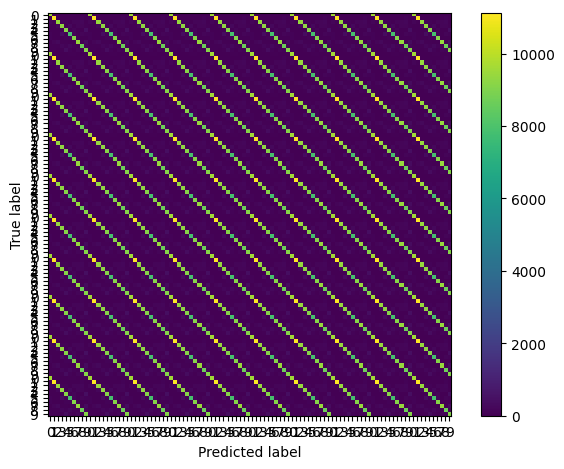

In [11]:
strategy.train(train_stream)
strategy.eval(test_stream)

# Get metrics

In [12]:
accuracies: dict[int, list[float]] = dict()
forgettings: dict[int, list[float]] = dict()
bwt: dict[int, list[float]] = dict()
class_accuracies: dict[int, list[float]] = dict()
losses: dict[int, list[float]] = dict()

for i in range(N_EXPERIENCES):
    filled_i = str(i).zfill(3)
    accuracies[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp{filled_i}"
    ][1]
    forgettings[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"ExperienceForgetting/eval_phase/test_stream/Task000/Exp{filled_i}"
    ][1]
    bwt[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"ExperienceBWT/eval_phase/test_stream/Task000/Exp{filled_i}"
    ][1]
    class_accuracies[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/{i}"
    ][1]
    losses[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"Loss_Exp/eval_phase/test_stream/Task000/Exp{filled_i}"
    ][1]
        

accuracies["Overall"] = eval_plugin.get_all_metrics()[
    "Top1_Acc_Stream/eval_phase/test_stream/Task000"
][1]

In [13]:
train_cpu_usage = eval_plugin.get_all_metrics()["CPUUsage_MB/train_phase/train_stream/Task000"][1]
train_time_epoch = eval_plugin.get_all_metrics()["Time_Epoch/train_phase/train_stream/Task000"][1]
train_running_time = eval_plugin.get_all_metrics()["RunningTime_Epoch/train_phase/train_stream/Task000"][1]
train_loss_epoch = eval_plugin.get_all_metrics()["Loss_MB/train_phase/train_stream/Task000"][1]

In [14]:
weights = model_plugins[0].weights

# Store metrics

In [15]:
pickle.dump({
    "accuracies": accuracies,
    "forgettings": forgettings,
    "bwt": bwt,
    "class_accuracies": class_accuracies,
    "losses": losses,
    "train_cpu_usage": train_cpu_usage,
    "train_time_epoch": train_time_epoch,
    "train_running_time": train_running_time,
    "train_loss_epoch": train_loss_epoch,
    "weights": weights
}, open(SAVED_METRICS_PATH / METRICS_FILENAME, "wb"))